In [99]:
import numpy as np
import pandas as pd

pd.options.display.float_format = '{:.3f}'.format

from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.expand_frame_repr = False

In [100]:
from scipy.stats import kstest
from scipy.stats import shapiro
from scipy.stats import chisquare
from scipy.stats import jarque_bera
from scipy.stats import cramervonmises
from scipy.stats import normaltest, norm
from scipy.stats import anderson
from scipy.stats import zscore

In [101]:
from scipy.stats import ttest_ind
from scipy.stats import levene
from scipy.stats import f_oneway
from scipy.stats import bartlett

In [102]:
def point_metrics(data_):
    conf = 0.95
    std = np.std(data_, ddof=1)
    mean = np.mean(data_)
    median = np.median(data_)
    print(f'Выборочное среднее == {mean}\n'
          f'Медианное значение == {median}\n'
          f'Стандартное отклонение == {std}\n'
          f'Выборочная дисперсия == {np.var(data_, ddof=1)}\n'
          f'I-ая квартиля == {np.percentile(data_, 25)}\n'
          f'II-ая квартиля == {np.percentile(data_, 75)}\n'
          f'Дов. Интервал с выборочным средним: {norm.interval(conf, loc=mean, scale=std)}\n'
          f'Дов. Интервал с медианным значением: {norm.interval(conf, loc=median, scale=std)}\n\n')


In [103]:
def fill_zeros(f_obs, f_exp):
    """ Fill zero bins """
    observed = []
    expected = []

    k = 0
    while k < len(f_exp):
        _f = f_obs[k]
        f_ = f_exp[k]
        while (_f <= 5 or f_ <= 5) and k < len(f_exp) - 1:
            k += 1
            _f += f_obs[k]
            f_ += f_exp[k]

        if (_f <= 5 or f_ <= 5) and k == len(f_exp) - 1:
            observed[-1] += _f
            expected[-1] += f_
        else:
            observed.append(_f)
            expected.append(f_)
        k += 1

    return observed, expected


def check_for_norm(data_):
    """ Check for normal distribution"""
    data_ = zscore(data_)

    observed_frequencies, bins = np.histogram(data_, bins='auto')
    cdf = norm.cdf(data_, loc=np.mean(data_), scale=np.std(data_))
    expected_frequencies, bins = np.histogram(cdf, bins=len(observed_frequencies))
    observed_frequencies, expected_frequencies = fill_zeros(observed_frequencies, expected_frequencies)
    print(sum(observed_frequencies), sum(expected_frequencies))
    print(observed_frequencies, expected_frequencies)

    chi = chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)

    res = cramervonmises(data_, 'norm')
    anderson_stat, anderson_critical, significance_level = anderson(data_, dist='norm')

    v = [
        ['Chi-square', chi.statistic, chi.pvalue],
        ['D’Agostino and Pearson', *normaltest(data_, nan_policy='propagate')],
        ['Jarque-Bera', *jarque_bera(data_)],
        ['Shapiro-Wilk', *shapiro(data_)],
        ['Anderson', anderson_stat, anderson_critical[2]],
        [None, None, None],
        ['Cramér-von Mises', res.statistic, res.pvalue],  # not good for 'norm' 
        ['Kolmogorov-Smirnov', *kstest(data_, cdf=norm.cdf)],  # not good 'norm'
    ]

    return_df = pd.DataFrame(v, columns=['Method_Name', 'statistics', 'p_value'])
    print(return_df)

In [104]:
def some_fun(l, ax, title=None):
    h_g = sns.histplot(data=l, bins='auto', discrete=False, kde=True, ax=ax)
    h_g.set_title(title)

####

In [105]:
data = pd.DataFrame(columns=["Index",
                             "Weight",
                             "Batch"])

file = open('euroweight.dat.txt', 'r')

for line in file:
    words = line.split()
    data.loc[len(data.index)] = words

data["Index"] = data["Index"].astype(int)
data["Weight"] = data["Weight"].astype(float)
data["Batch"] = data["Batch"].astype(int)
data.head(10)

,Index,Weight,Batch
0,1,7.512,1
1,2,7.502,1
2,3,7.461,1
3,4,7.562,1
4,5,7.528,1
5,6,7.459,1
6,7,7.518,1
7,8,7.537,1
8,9,7.517,1
9,10,7.605,1


### Исследуем вес монет на нормальность

Исследуем вес Batch-1: 
250 250
[10, 12, 32, 42, 40, 38, 35, 24, 17] [40, 24, 18, 19, 20, 18, 11, 18, 82]
              Method_Name  statistics  p_value
0              Chi-square     215.341    0.000
1  D’Agostino and Pearson       1.210    0.546
2             Jarque-Bera       1.295    0.523
3            Shapiro-Wilk       0.996    0.683
4                Anderson       0.359    0.775
5                    None         NaN      NaN
6        Cramér-von Mises       0.064    0.792
7      Kolmogorov-Smirnov       0.039    0.832
Выборочное среднее == 7.519656
Медианное значение == 7.5175
Стандартное отклонение == 0.03436132223683273
Выборочная дисперсия == 0.001180700465863455
I-ая квартиля == 7.494
II-ая квартиля == 7.543749999999999
Дов. Интервал с выборочным средним: (7.452309045954633, 7.587002954045368)
Дов. Интервал с медианным значением: (7.450153045954632, 7.584846954045368)


Исследуем вес Batch-2: 
250 250
[10, 10, 23, 27, 33, 47, 32, 23, 23, 14, 8] [79, 10, 19, 11, 26, 15, 15, 13,

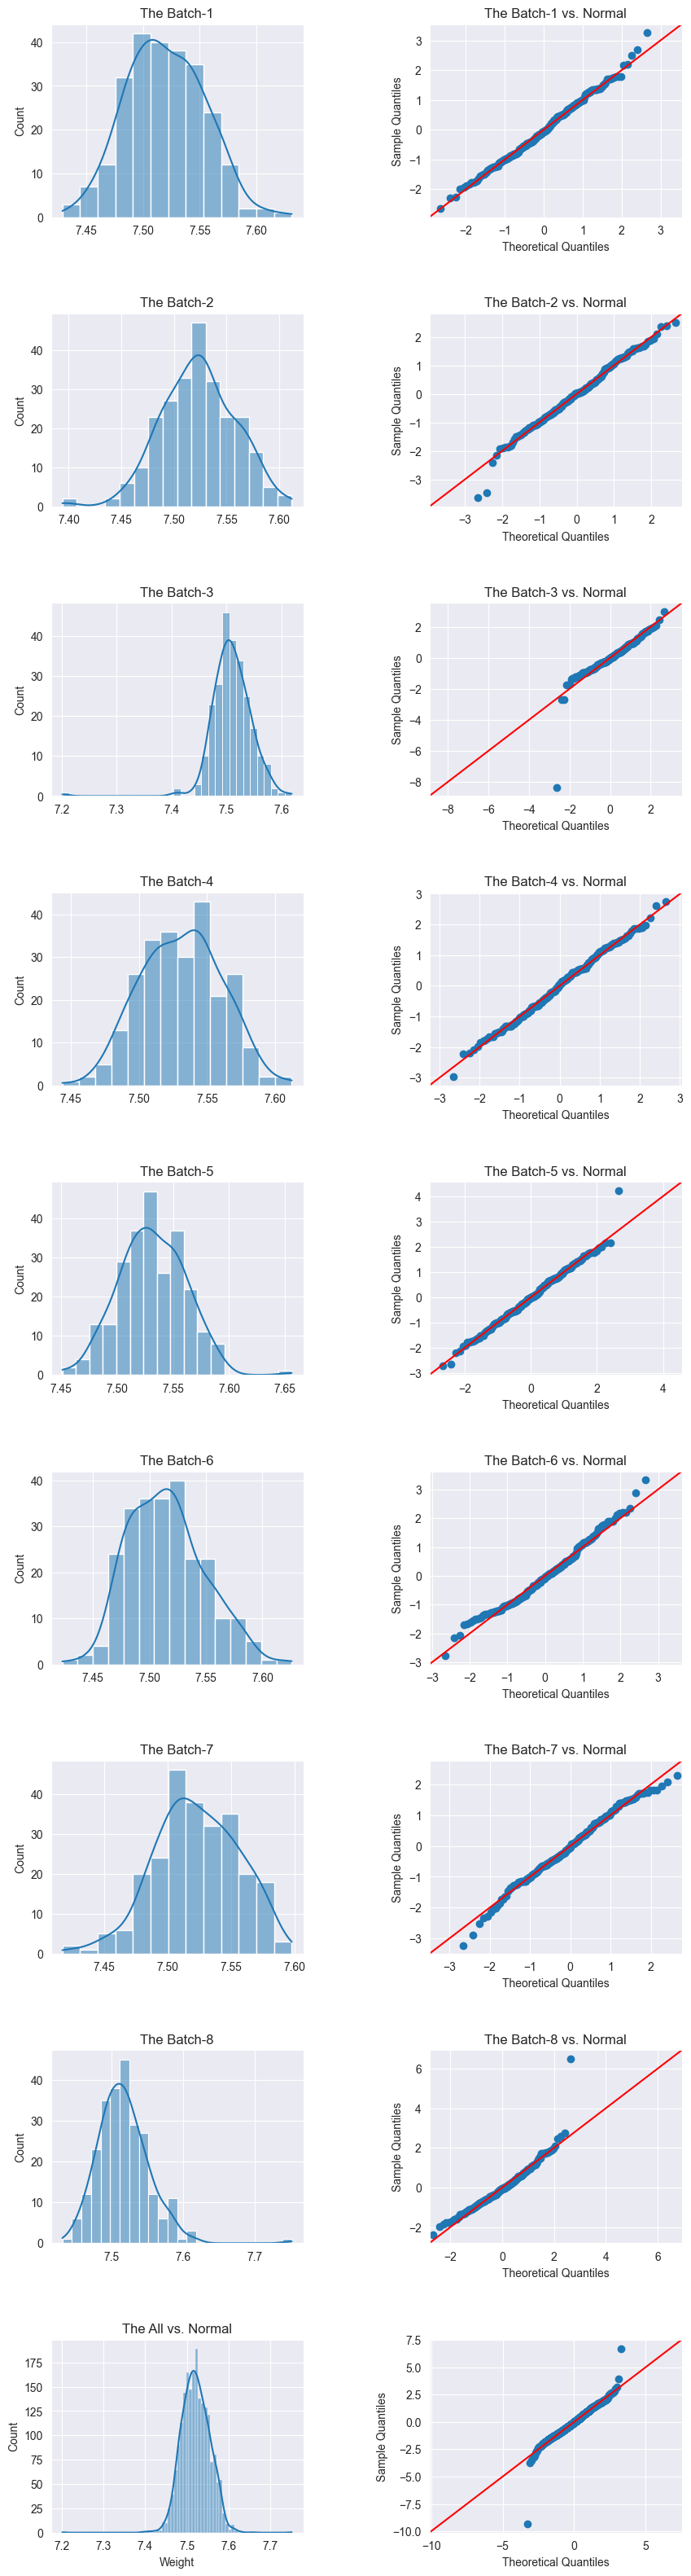

In [106]:
fig, axs = plt.subplots(ncols=2, nrows=9, figsize=(10, 40))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
grouped_data = data.groupby("Batch")

the_data = []
# Batches
for group, group_data in grouped_data:
    the_coin = group_data["Weight"].values
    the_data.append(the_coin)
    some_fun(l=the_coin, title=f'The Batch-{group}', ax=axs[group - 1][0])
    qqplot(zscore(the_coin ), line='45', ax=axs[group - 1][1])
    axs[group - 1, 1].set_title(f'The Batch-{group} vs. Normal')

    print(f"Исследуем вес Batch-{group}: ")
    check_for_norm(the_coin)
    point_metrics(the_coin)

# All
the_all = data["Weight"]
some_fun(l=the_all, title='The All', ax=axs[8][0])
qqplot(zscore(the_all), line='45', ax=axs[8][1])
axs[8, 0].set_title('The All vs. Normal')

print(f"Исследуем вес All: ")
check_for_norm(the_all)
point_metrics(the_all)

### Проверяем гипотезы о равенстве средних и дисперсий

In [107]:
for i, first in enumerate(the_data):
    for j, second in enumerate(the_data[(i+1):]):
        print('The Batch-{0} vs Batch-{1}:'.format(i, (i+1)+j))
        print('statistics: {:.3f} p-value: {:.3f} - T-test(mean)'.format(*ttest_ind(first, second)))
        print('statistics: {:.3f} p-value: {:.3f} - Levene(dispersion)'.format(*levene(first, second)))

print('The All Batches:')
print('statistics: {:.3f} p-value: {:.3f} - ANOVA(mean)'.format(*f_oneway(*the_data)))
print('statistics: {:.3f} p-value: {:.3f} - Bartlett(dispersion)'.format(*bartlett(*the_data)))

The Batch-0 vs Batch-1:
statistics: -1.124 p-value: 0.261 - T-test(mean)
statistics: 0.009 p-value: 0.926 - Levene(dispersion)
The Batch-0 vs Batch-2:
statistics: 3.164 p-value: 0.002 - T-test(mean)
statistics: 1.045 p-value: 0.307 - Levene(dispersion)
The Batch-0 vs Batch-3:
statistics: -4.002 p-value: 0.000 - T-test(mean)
statistics: 5.212 p-value: 0.023 - Levene(dispersion)
The Batch-0 vs Batch-4:
statistics: -4.091 p-value: 0.000 - T-test(mean)
statistics: 6.445 p-value: 0.011 - Levene(dispersion)
The Batch-0 vs Batch-5:
statistics: 1.457 p-value: 0.146 - T-test(mean)
statistics: 0.452 p-value: 0.502 - Levene(dispersion)
The Batch-0 vs Batch-6:
statistics: -1.115 p-value: 0.265 - T-test(mean)
statistics: 0.435 p-value: 0.510 - Levene(dispersion)
The Batch-0 vs Batch-7:
statistics: 0.923 p-value: 0.357 - T-test(mean)
statistics: 0.205 p-value: 0.651 - Levene(dispersion)
The Batch-1 vs Batch-2:
statistics: 4.199 p-value: 0.000 - T-test(mean)
statistics: 0.818 p-value: 0.366 - Levene(